In [1]:
using Plots, Distributions;
using AugmentedGaussianProcesses;

In [2]:
# Generate data from a mixture of gaussians (you can control the noise)
N_data = 500; N_dim = 2; N_grid = 100
minx=-2.5; maxx=3.5
σs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]; N_class = N_dim + 1

function generate_mixture_data(σ)
    centers = zeros(N_class,N_dim)
    for i in 1:N_dim
        centers[i,i] = 1
    end
    centers[end,:] = (1+sqrt(N_class))/N_dim*ones(N_dim); centers ./= sqrt(N_dim)
    ## Generate distributions with desired noise
    distr = [MvNormal(centers[i,:],σ) for i in 1:N_class]
    X = zeros(Float64,N_data,N_dim)
    y = zeros(Int64,N_data)
    true_py = zeros(Float64,N_data)
    for i in eachindex(y)
        y[i] = rand(1:N_class)
        X[i,:] = rand(distr[y[i]])
        true_py[i] = pdf(distr[y[i]],X[i,:])/sum(pdf(distr[k],X[i,:]) for k in 1:N_class)
    end
    return X,y
end
## Create equidistant centers


generate_mixture_data (generic function with 1 method)

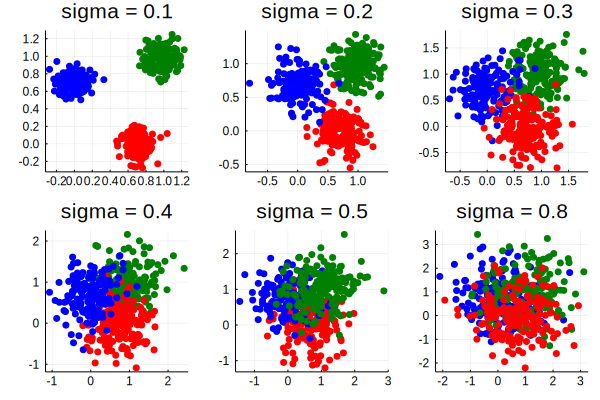

In [3]:
function plotdata(X,Y,σ)
    p = Plots.plot(size(300,500),lab="",title="sigma = $σ")
    ys = unique(Y)
    cols = [:red,:blue,:green]
    for y in ys
        Plots.plot!(X[Y.==y,1],X[Y.==y,2],color=cols[y],alpha=1.0,t=:scatter,markerstrokewidth=0.0,lab="");
    end
    return p
end;
plot([plotdata(generate_mixture_data(σ)...,σ) for σ in σs]...)

In [4]:
# Run sparse multiclass classification with increasing number of inducing points
# Ms = [4, 8, 16, 32, 64]
models = Vector{AbstractGP}(undef,length(σs))
kernel = RBFKernel(1.0,variance=10.0)
num_inducing = 50
for (index, σ) in enumerate(σs)
    m = SVGP(generate_mixture_data(σ)..., kernel,LogisticSoftMaxLikelihood(),AnalyticVI(),num_inducing)
    println("Training with data with noise $σ")
    @time train!(m,iterations=20)
    models[index]=m;
end

Training with data with noise 0.1
  8.826585 seconds (39.49 M allocations: 2.157 GiB, 9.89% gc time)
Training with data with noise 0.2
  0.179287 seconds (161.19 k allocations: 215.665 MiB, 10.89% gc time)
Training with data with noise 0.3
  0.184828 seconds (161.19 k allocations: 215.665 MiB, 9.43% gc time)
Training with data with noise 0.4
  0.178242 seconds (161.19 k allocations: 215.665 MiB, 9.82% gc time)
Training with data with noise 0.5
  0.184192 seconds (161.19 k allocations: 215.665 MiB, 9.19% gc time)
Training with data with noise 0.8
  0.181190 seconds (161.19 k allocations: 215.665 MiB, 9.80% gc time)


In [5]:
function compute_Grid(model,nGrid=50)
    xlin = range(minx,stop=maxx,length=nGrid)
    ylin = range(minx,stop=maxx,length=nGrid)
    Xplot = hcat([j for i in xlin, j in ylin][:],[i for i in xlin, j in ylin][:])
    y_p =  proba_y(model,Xplot)
    y =  predict_y(model,Xplot)
    return (y_p,y,xlin,ylin)
    end;

In [8]:
function plotcontour(model,σ)
    nGrid = 100
    (predic_proba,predic,x,y) = compute_Grid(model,nGrid);
    cols = reshape([RGB(permutedims(Vector(predic_proba[i,:]))[collect(values(sort(model.likelihood.ind_mapping)))]...) for i in 1:nGrid*nGrid],nGrid,nGrid)
    Plots.plot(x,y,cols,cbar=false,t=:contour,fill=false,color=:black,linewidth=2.0,title="sigma = $σ")
    Plots.plot!(x,y,reshape(predic,nGrid,nGrid),clims=(0,100),t=:contour,colorbar=false,color=:gray,levels=10)
end;

## Here we plot the likelihood of each point by a RGB mapping

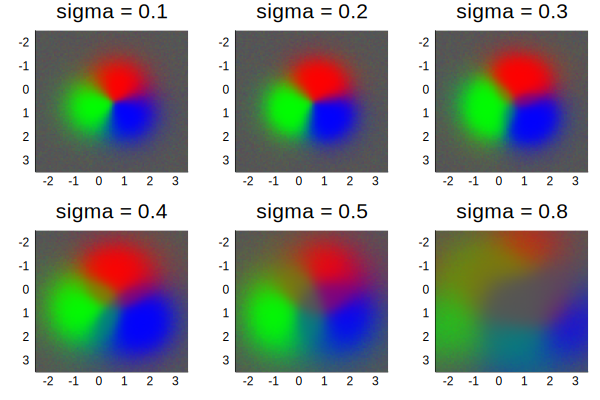

In [9]:
Plots.plot(broadcast((x,σ)->plotcontour(x,σ),models,σs)...)